# making personalised models (1 model per pp)
gonna use hyperparams from tuning on all pps ('min_samples_leaf': 200, 'max_depth': 500, 'criterion': 'entropy')

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pykalman import KalmanFilter
import os
from sklearn.model_selection import train_test_split , cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance


# on 1 min aggregated

In [37]:
dir_in = 'D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSensors_allPPs'
os.chdir(dir_in)
# df = pd.read_csv('all_data_FINAL.csv')

df = pd.read_csv('all_data_final_kalmanFilled.csv')

In [38]:
num_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'duration', 'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
 'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur', 'pause_dur', 'pause_rate']

feature_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'Rclick', 'Lclick', 'keyPress', 'move_dist','move_duration']

# feature_cols = num_cols

In [49]:
#creating ordered list of all pps
pp_lst = list(set(df['pp_id']))
pp_lst.sort()
# pp_lst


# creating function that cv & trains of full data

In [45]:

def run_cv_dt (df):
    print('making model for pp '+str(set(df['pp_id'])))
    #1st split data
    x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['condition'],  test_size=0.20, random_state=42)

    #scale
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #using hyperparams of model tuned on all pps
    # model = DecisionTreeClassifier(min_samples_leaf=200, max_depth=500, criterion='entropy',  random_state=42 )
    model = DecisionTreeClassifier( random_state=42 )
# 

    cv_scores = cross_val_score(model, x_train_scaled, y_train,  scoring='accuracy', cv=5) 

    print('cross val scores: {}'.format(cv_scores))

    #then can train on full data & check performance on test set (never seen before). 
    print('now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!')
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    print('\n classification  report on full data (run only once!)')
    print(classification_report(y_test, y_pred))
    test_acc =accuracy_score(y_test, y_pred)
#  should get permuttion importance features in here (and return it, it will be per pp)
    perm_imp = permutation_importance(model, x_test_scaled, y_test, n_repeats=5, random_state=42, scoring='accuracy', n_jobs=-1)
    return model, cv_scores, test_acc, perm_imp

# applying to 1 in aggregated data

In [46]:
from sklearn import tree
#looping opver pps
pp_models_lst=[] ; pp_train_scores=[] ; pp_test_acc=[]
feat_imp = [] #stores the tree feature importance (of train) (tree)
perm_imp = [] #stores the permutation importance of test (model agnostic)
for pp in pp_lst:
    curr_df = df.loc[df['pp_id']==pp].reset_index().copy()
    curr_model, curr_cv_scores, curr_test_acc, curr_perm_imp = run_cv_dt(curr_df)
    pp_models_lst.append(curr_model)
    pp_train_scores.append(curr_cv_scores)
    pp_test_acc.append(curr_test_acc)
    
    feat_imp.append(curr_model.tree_.compute_feature_importances())
    perm_imp.append(curr_perm_imp)

    
    # plt.figure(figsize=(25,20))
    # _ = tree.plot_tree(curr_model,
    #                 feature_names = feature_cols,
    #                 class_names = ['N','S'],
    #                 # max_depth=500,
    #                 #  class_names = True,
    #                 filled=True)
    # plt.savefig('D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSesonrs_allPPs_testing\\'+str(pp) +'tree.png', dpi=100)


making model for pp {'pp02'}
cross val scores: [1.  0.9 1.  1.  1. ]
now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!

 classification  report on full data (run only once!)
              precision    recall  f1-score   support

           N       1.00      1.00      1.00         4
           S       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

making model for pp {'pp03'}
cross val scores: [0.8        0.9        0.9        0.88888889 0.88888889]
now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!

 classification  report on full data (run only once!)
              precision    recall  f1-score   support

           N       0.75      0.75      0.75         4
           S       0.88      0.88      0.88         8

    accuracy                           0

### plotting personalised model results

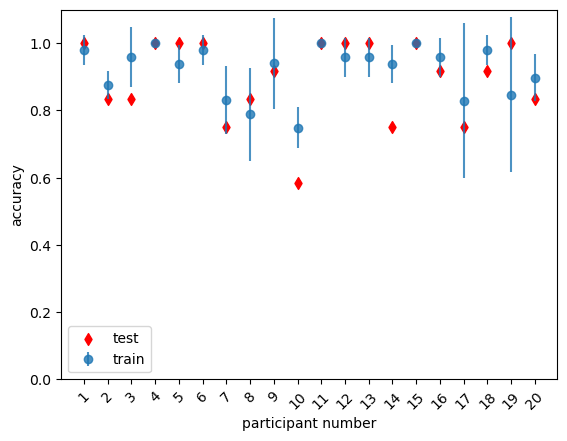

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

res_df = pd.DataFrame()
res_df['pp_id'] = pp_lst
res_df['mean_train_acc'] = [x.mean() for x in pp_train_scores]
res_df['std_train_acc']= [stdev(x) for x in pp_train_scores]
res_df['test_acc'] = pp_test_acc

ax=plt.subplot(111)
plt.errorbar(x= res_df.index, y= res_df['mean_train_acc'], yerr=res_df['std_train_acc'], fmt="o", label ='train', alpha=0.8)
plt.scatter(res_df.index, res_df['test_acc'], marker = 'd', color='red', label='test')
# ax.set_xticks( ticks= res_df.index, labels= res_df['pp_id'], rotation=45) to make x axis with actual pp number
ax.set_xticks( ticks= res_df.index, labels= range(1,21), rotation=45)
ax.set_ylim(0, 1.1)
plt.xlabel('participant number')
plt.ylabel('accuracy')
plt.legend()

#### doin TREE feature importance (of train)

In [97]:
# imp_df = pd.DataFrame(data=feat_imp, columns=feature_cols, index=pp_lst)
# print(imp_df.shape)
# imp_df.head()

# # print(len(feature_cols))
# # len(feat_imp)
# # imp.to_csv('D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSesonrs_allPPs_testing\\personalisedModels_featImp.csv')



##### pooled importance over all pps

In [96]:
imp_df = pd.DataFrame(data=feat_imp, columns=feature_cols, index=pp_lst)
pooled_imp = imp_df.sum(axis=0)
pooled_imp_normalised = pooled_imp/np.sum(pooled_imp)
pooled_imp_normalised

AU1_InnerBrowRaiser         0.000000
AU2_OuterBrowRaiser         0.000000
AU4_BrowLowerer             0.013212
AU5_UpperLipRaiser          0.000000
AU6_CheekRaiser             0.000000
AU7_LidTightener            0.000000
AU9_NoseWringler            0.007792
AU10_UpperLipRaiser         0.008054
AU12_LipCornerPuller        0.000000
AU14_Dimpler                0.000000
AU15_LipCornerDepressonr    0.010680
AU17_ChinRaiser             0.000000
AU20_LipStretcher           0.025301
AU23_LipTightener           0.000000
AU25_LipsPart               0.000000
AU26_JawDrop                0.000000
AU45_BlinkInt               0.013531
AUc45_BlinkRate             0.000000
AUc28_LipSuck               0.000000
headOrient_x                0.305075
headOrient_y                0.049014
headOrient_z                0.176179
gazeCenter                  0.010789
gazeUp                      0.038598
gazeDown                    0.103579
gazeRight                   0.085090
gazeLeft                    0.004895
R

In [109]:
len(pooled_imp_normalised)
len(feature_cols)

32

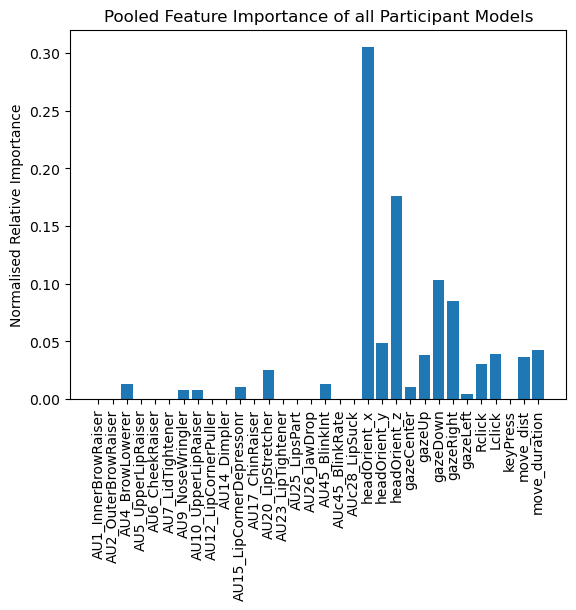

In [116]:
plt.subplot(111)
plt.bar(range(len(feature_cols)), pooled_imp_normalised)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.title('Pooled Feature Importance of all Participant Models')
plt.ylabel('Normalised Relative Importance')

# ax.set_xticks(range(len(feature_cols)), labels = feature_cols, rotate=45)
plt.show()

##### indiv importance across all pps

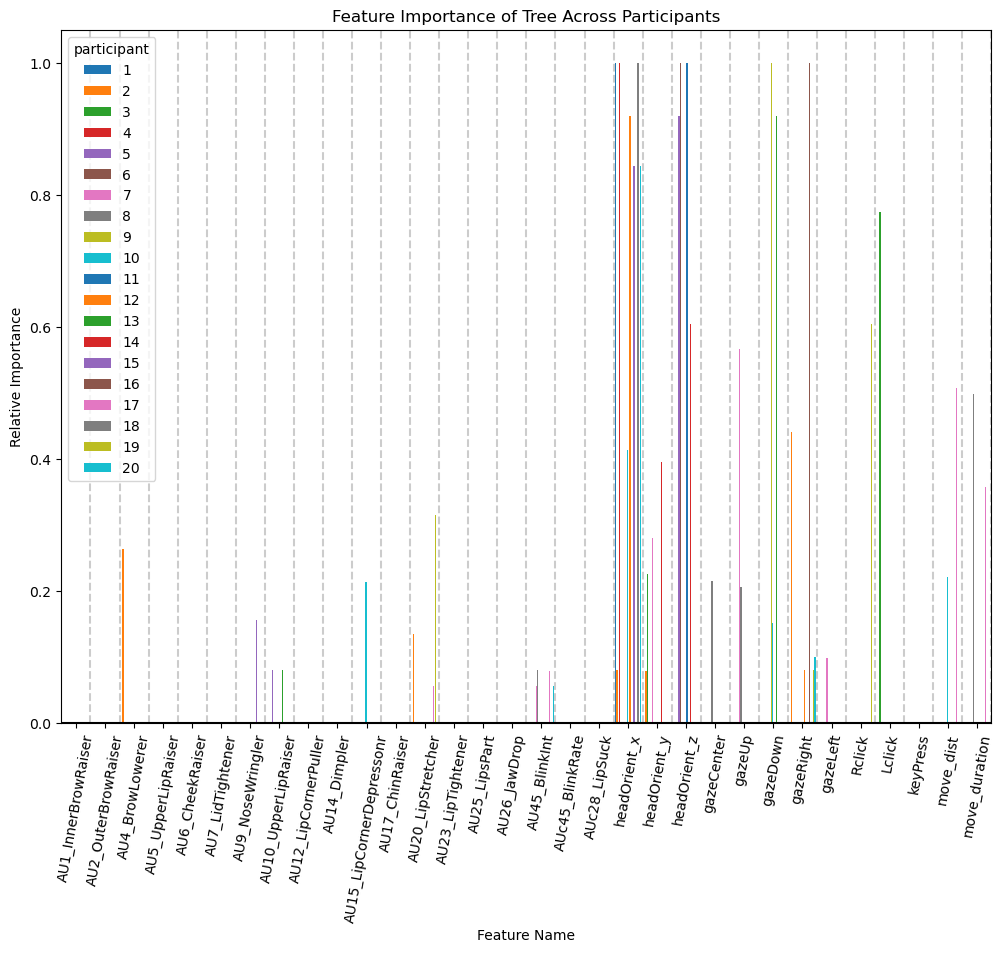

In [120]:
def plot_feat_imp_tree(feat_imp_lst, names):
    
    # feat_imp_df = pd.DataFrame(data=feat_imp_lst, columns=feature_cols, index=pp_lst)#for actual participant names
    feat_imp_df = pd.DataFrame(data=feat_imp_lst, columns=feature_cols, index=names)
    graph_data = feat_imp_df
    graph_data.reset_index(inplace=True, drop=False)
    graph_data.rename(columns={'index': 'participant'}, inplace=True)
    graph_data = graph_data.melt(id_vars='participant')
    # create visual
    plt.figure(figsize=[12,9])
    plt.axhline(0, c='black')
    [plt.axvline(i + 0.5, linestyle='--', c='black', alpha=0.2) for i in range(0, len(feature_cols))]
    sns.barplot(x=graph_data['variable'], y=graph_data['value'], hue=graph_data['participant'],\
                palette=sns.color_palette("tab10"), saturation=1, width=0.9)
    plt.title("Feature Importance of Tree Across Participants")
    plt.xlabel("Feature Name")
    plt.ylabel("Relative Importance")
    plt.xticks(rotation=80)
    # plt.tight_layout()


# plot_feat_imp_tree(feat_imp, pp_lst) for actual participant labels
plot_feat_imp_tree(feat_imp, range(1,21))

### can also do permutation importance of training AND testing sets ! - didnt use this

https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa



In [78]:
def plot_perm_imp(perm_res_lst, names):
    ##  extract data and names from permutation results
    graph_data = {}
    for result, name in zip(perm_res_lst, names):
        graph_data[name] = result['importances_mean']
    ## make final dataframe
    graph_data = pd.DataFrame.from_dict(graph_data, orient='index', columns=feature_cols)
    graph_data.reset_index(inplace=True, drop=False)
    graph_data.rename(columns={'index': 'participant'}, inplace=True)
    graph_data = graph_data.melt(id_vars='participant')
    # create visual
    plt.figure(figsize=[12,11])
    plt.axhline(0, c='black')
    [plt.axvline(i + 1, linestyle='--', c='black', alpha=0.5) for i in range(0, len(feature_cols))]
    sns.barplot(x=graph_data['variable'], y=graph_data['value'], hue=graph_data['participant'],\
                palette=sns.color_palette("tab10"), saturation=1, width=0.9)
    plt.title("Permutation Feature Importance for Test Set Across Participants")
    plt.xlabel("Feature Name")
    plt.ylabel("Change in Accuracy")
    plt.xticks(rotation=80)


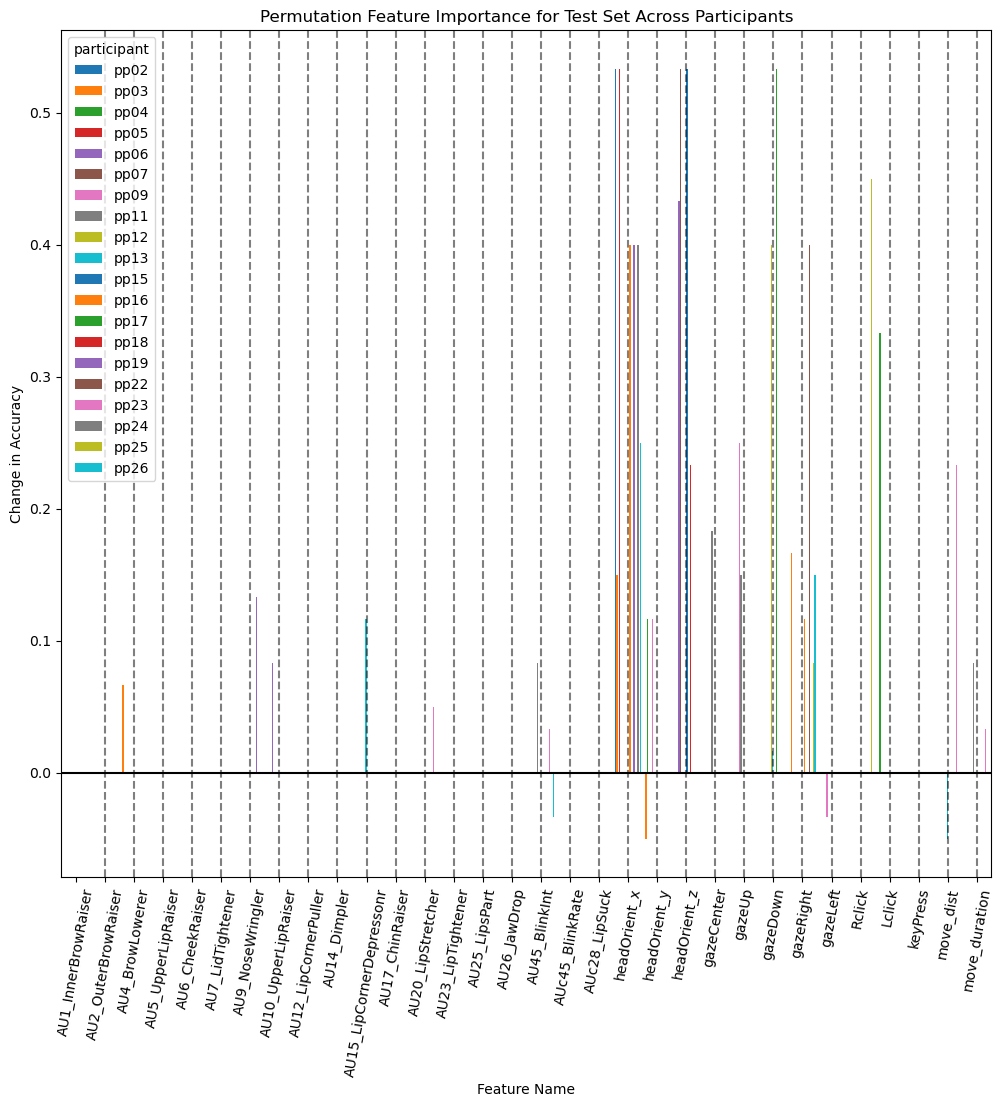

In [79]:
plot_perm_imp(perm_imp, pp_lst)

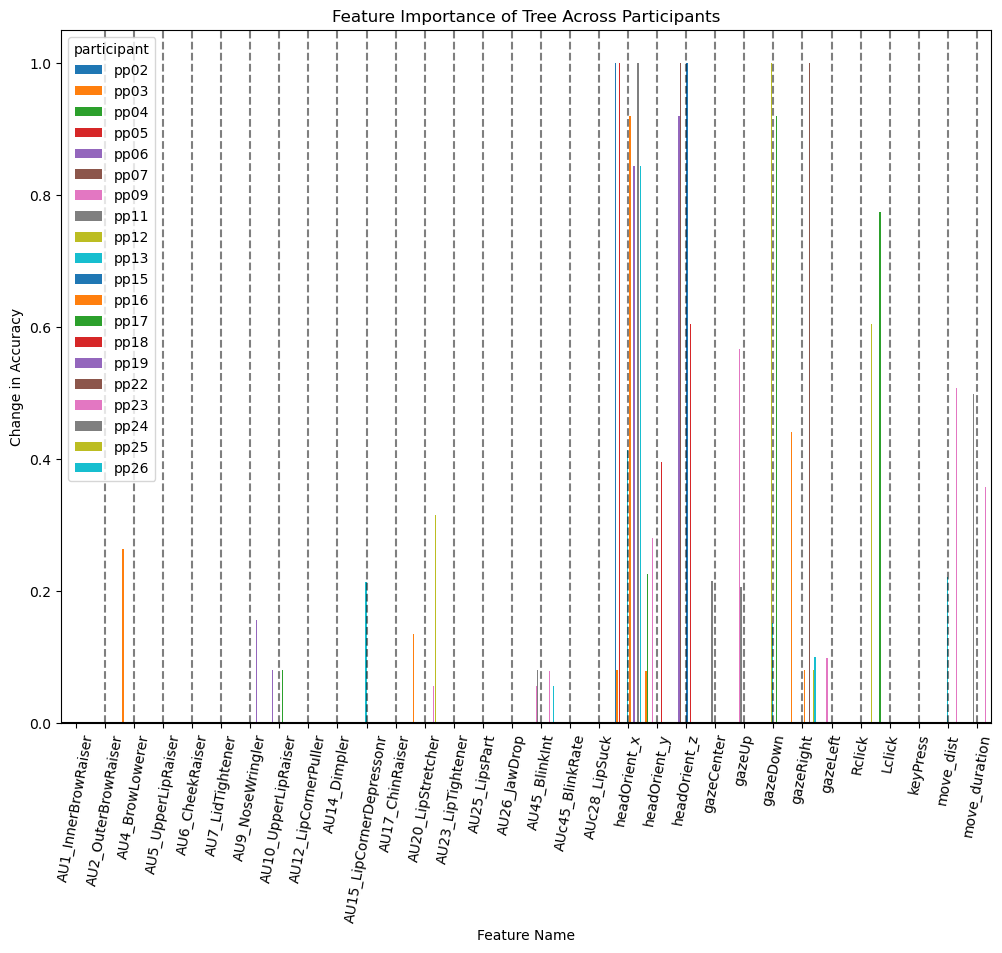

In [13]:
# from sklearn.inspection import permutation_importance
# model=DecisionTreeClassifier()
# x_train, x_test_scaled, y_train, y_test = train_test_split(df[feature_cols], df['condition'],  test_size=0.20, random_state=42)
# model.fit(x_train, y_train)
# # for ppmodel in pp_models_lst:
# perm_imp_pp1 = permutation_importance(model, x_test_scaled, y_test, n_repeats=5, random_state=42, scoring='accuracy', n_jobs=-1)

In [41]:
# perm_res = [perm_imp_pp1, perm_imp_pp1]#will have this list with perm_imp per pp
# names = ['pp1', 'pp2'] #its the pp_lst



SyntaxError: invalid syntax (1772641036.py, line 4)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'AU1_InnerBrowRaiser'),
  Text(1, 0, 'AU2_OuterBrowRaiser'),
  Text(2, 0, 'AU4_BrowLowerer'),
  Text(3, 0, 'AU5_UpperLipRaiser'),
  Text(4, 0, 'AU6_CheekRaiser'),
  Text(5, 0, 'AU7_LidTightener'),
  Text(6, 0, 'AU9_NoseWringler'),
  Text(7, 0, 'AU10_UpperLipRaiser'),
  Text(8, 0, 'AU12_LipCornerPuller'),
  Text(9, 0, 'AU14_Dimpler'),
  Text(10, 0, 'AU15_LipCornerDepressonr'),
  Text(11, 0, 'AU17_ChinRaiser'),
  Text(12, 0, 'AU20_LipStretcher'),
  Text(13, 0, 'AU23_LipTightener'),
  Text(14, 0, 'AU25_LipsPart'),
  Text(15, 0, 'AU26_JawDrop'),
  Text(16, 0, 'AU45_BlinkInt'),
  Text(17, 0, 'AUc45_BlinkRate'),
  Text(18, 0, 'AUc28_LipSuck'),
  Text(19, 0, 'headOrient_x'),
  Text(20, 0, 'headOrient_y'),
  Text(21, 0, 'headOrient_z'),
  Text(22, 0, 'gazeCenter'),
  Text(23, 0, 'gazeUp'),
  Text(24, 0, 'gazeDown'),
  Text(25, 0, 'gazeRi

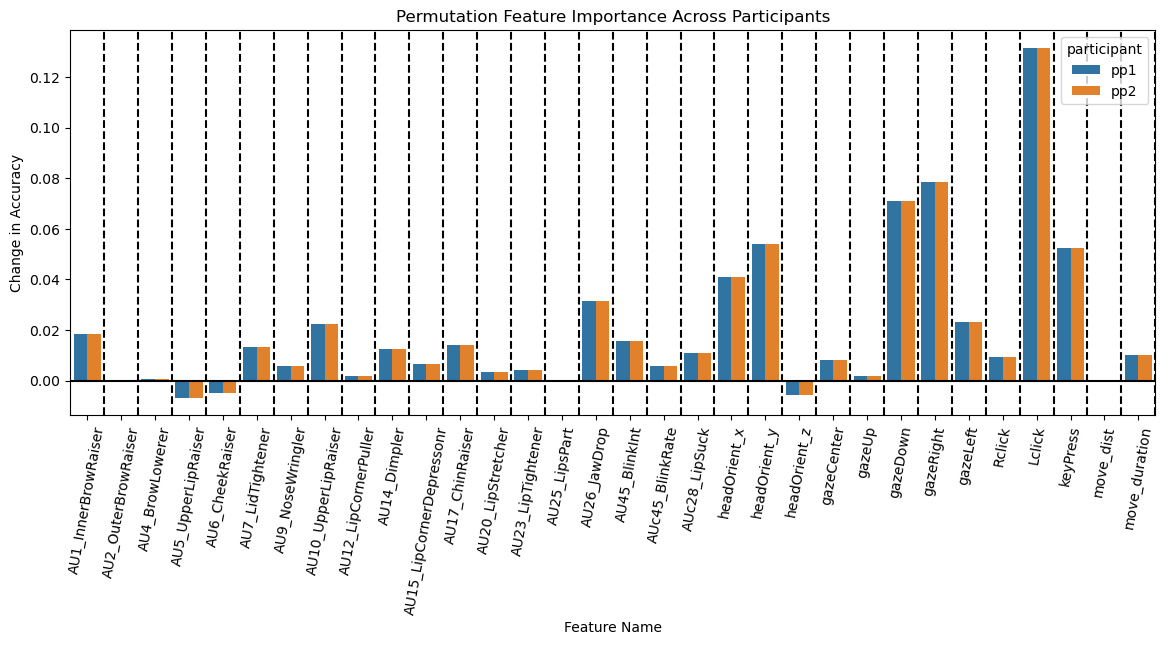

In [86]:
# for i in range(len(pp_scores)):
#     print()
#     print('train')
#     print(pp_train_scores[i].mean())
#     print('test')
#     print(pp_test_acc[i])



train
0.9800000000000001
test
1.0

train
0.7488888888888889
test
0.0

train
0.8577777777777778
test
0.9166666666666666

train
1.0
test
1.0

train
0.9
test
1.0

train
0.9355555555555555
test
1.0

train
0.7977777777777777
test
0.0

train
0.6044444444444445
test
0.6666666666666666

train
0.8800000000000001
test
0.5833333333333334

train
0.5
test
0.08333333333333333

train
0.9800000000000001
test
1.0

train
0.96
test
0.9166666666666666

train
0.7955555555555556
test
1.0

train
0.8800000000000001
test
0.5

train
0.8511111111111112
test
0.0

train
0.8355555555555554
test
0.75

train
0.47777777777777775
test
0.9166666666666666

train
0.9400000000000001
test
0.8333333333333334

train
0.7177777777777778
test
0.8333333333333334

train
0.7822222222222222
test
0.6666666666666666


# applying to 30sec aggregated data

In [3]:

dir_in = 'D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSensors_allPPs\\30sec_aggr_allData'
os.chdir(dir_in)
# df = pd.read_csv('all_data_FINAL.csv')

df = pd.read_csv('all_data_30sec_kalmanFiltered.csv')

In [4]:
num_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'duration', 'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
 'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur', 'pause_dur', 'pause_rate']

feature_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'Rclick', 'Lclick', 'keyPress', 'move_dist','move_duration']

# feature_cols = num_cols



In [5]:
#creating ordered list of all pps
pp_lst = list(set(df['pp_id']))
pp_lst.sort()
pp_lst


['pp02',
 'pp03',
 'pp04',
 'pp05',
 'pp06',
 'pp07',
 'pp09',
 'pp11',
 'pp12',
 'pp13',
 'pp15',
 'pp16',
 'pp17',
 'pp18',
 'pp19',
 'pp22',
 'pp23',
 'pp24',
 'pp25',
 'pp26']

In [11]:
#looping opver pps
pp_models_lst=[] ; pp_train_scores=[] ; pp_test_acc=[]
for pp in pp_lst:
    curr_df = df.loc[df['pp_id']==pp].reset_index().copy()
    curr_model, curr_cv_scores, curr_test_acc = run_cv_dt(curr_df)
    pp_models_lst.append(curr_model)
    pp_train_scores.append(curr_cv_scores)
    pp_test_acc.append(curr_test_acc)


making model for pp {'pp02'}
cross val scores: [1.         1.         1.         1.         0.94736842]
now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!

 classification  report on full data (run only once!)
              precision    recall  f1-score   support

           N       1.00      1.00      1.00        13
           S       1.00      1.00      1.00        11

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

making model for pp {'pp03'}
cross val scores: [0.95       0.94736842 0.84210526 0.78947368 0.89473684]
now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!

 classification  report on full data (run only once!)
              precision    recall  f1-score   support

           N       0.92      0.92      0.92        13
           S       0.91      0.91      0.91        11

    a

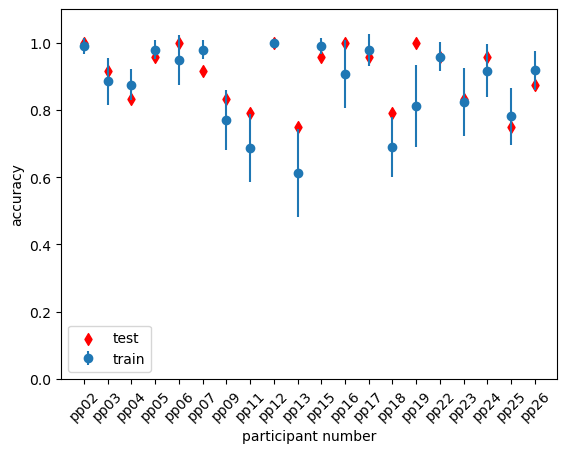

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

res_df = pd.DataFrame()
res_df['pp_id'] = pp_lst
res_df['mean_train_acc'] = [x.mean() for x in pp_train_scores]
res_df['std_train_acc']= [stdev(x) for x in pp_train_scores]
res_df['test_acc'] = pp_test_acc

ax=plt.subplot(111)
plt.errorbar(x= res_df.index, y= res_df['mean_train_acc'], yerr=res_df['std_train_acc'], fmt="o", label ='train')
plt.scatter(res_df.index, res_df['test_acc'], marker = 'd', color='red', label='test')
ax.set_xticks( ticks= res_df.index, labels= res_df['pp_id'], rotation=45)
ax.set_ylim(0, 1.1)
plt.xlabel('participant number')
plt.ylabel('accuracy')
plt.legend()